The aim of the project is to show the method of adaptive integration using Simpson's quadrature and the advantages over ordinary quadrature in specific cases, as well as to present the risks that may appear in a given algorithm.

I will use separate methods - one to get the best performance, the other to visualize the partition.

I will use the following structure to present the sub-intervals and construct the last method:

In [1]:
from time import time
from dataclasses import dataclass

@dataclass
class Subinterval:
    left: float
    right: float
    f_left: float
    f_center: float
    f_right: float
    Simpson: float
        
    def simpson(left: float, right: float, f_left: float, f_center: float, f_right: float):
        return (right - left)/6.*(f_left + 4.*f_center + f_right)

It contains the ends of the sub-interval, the function values on both its edges and in the middle, and the Simpson quadrature value.

### Functions that will be used for tests in the first stage (along with analytically calculated integrals):

In [2]:
from math import sin, cos, exp, sqrt

f = lambda x: x*x
int_f = lambda x: 1./3.*x*x*x

g = lambda x: x*sin(x)
int_g = lambda x: sin(x)-x*cos(x)

h = lambda x: x*x + 2.*x + exp(-x)
int_h = lambda x: 1./3.*x*x*x + x*x - exp(-x)

### The method of "drawing" sub-intervals:

(step visualization)

In [3]:
from matplotlib import pyplot as plt
from typing import List

def get_division(subintervals: List[Subinterval]):
    nodes = []
    for subinterval in subintervals:
        if subinterval.left not in nodes:
            nodes.append(subinterval.left)
        if subinterval.right not in nodes:
            nodes.append(subinterval.right)
    nodes.sort()
    return nodes

def plot_division(subintervals: List[Subinterval]):
    nodes = get_division(subintervals)
    plt.step(nodes, nodes)
    plt.show()

### Definite integral on a given interval (with analytically determined primary function):

In [4]:
def integral(int_f, a: float = 0., b: float = 1.):
    return int_f(b) - int_f(a)

## Simpson's rule 

In the beginning, I will show the operation of the (complex) Simpson quadrature, and in the same way, I will present adaptive quadratures.

In [5]:
def simpson_quadrature(f, a: float = 0.0, b: float = 1.0, n: int = 1):
    h = (b - a)/n
    
    # main nodes of the quadrature
    x_k = lambda i: a + i*h
    X = [x_k(i) for i in range(0,n)]
    X.append(b)
    
    # middle nodes of the subintervals
    t_k = lambda x, y: 0.5*(x + y)
    T = [t_k(x_k(i), x_k(i + 1)) for i in range (0, n)]
    
    # the quadrature
    result = f(a) + f(b)
    result += sum(2.0*f(X[i]) for i in range(1,n))
    result += sum(4.0*f(T[i]) for i in range(0,n))
    result *= h/6.0
    
    return result

In this case, $[a, b]$ a is split into $n$ sub-intervals. The function value is computed $2n + 1$ times. For test functions, the results in the $[0,1]$ range are as follows:

In [6]:
S_non_f = simpson_quadrature(f, n = 16)
S_non_g = simpson_quadrature(g, n = 16)
S_non_h = simpson_quadrature(h, n = 16)

print(f'S_non(f) = {S_non_f}')
print(f'S_non(g) = {S_non_g}')
print(f'S_non(h) = {S_non_h}')

S_non(f) = 0.3333333333333333
S_non(g) = 0.30116866269938636
S_non(h) = 1.9654538955105967


Note that for function $f$, the result is equal to accurate integral - independently of $n$ since $f^{(4)} \equiv 0$. In the absence of an analytical (or a precisely determined) result, the error estimation below is strongly hypothetical for small $n$. For asymptotically small sub-intervals, it is a good approximation.

In [7]:
def error_estimation(S: float, expected: float = 0.0):
    return S - expected

In [8]:
E_non_f = error_estimation(S_non_f, expected = integral(int_f))
E_non_g = error_estimation(S_non_g, expected = integral(int_g))
E_non_h = error_estimation(S_non_h, expected = integral(int_h))

print(f'E_non(f) = {E_non_f}')
print(f'E_non(g) = {E_non_g}')
print(f'E_non(h) = {E_non_h}')

E_non(f) = 0.0
E_non(g) = -1.624037038183701e-08
E_non(h) = 3.34870575713353e-09


Division in a complex Simpson's quadrature is, of course, uniform.

In [9]:
def simpson_quadrature_intervals(f, a = 0.0, b = 1.0, n = 1):
    h = (b - a)/n
    Subintervals = []
    
    # main nodes of the quadrature
    x_k = lambda i: a + i*h
    X = [x_k(i) for i in range(0,n)]
    X.append(b)
        
    # construction of the sub-intervals
    Subintervals = [Subinterval(left = X[i], right = X[i+1],
                                f_left = f(X[i]), f_center = 0.5*(f(X[i])+f(X[i+1])), f_right = f(X[i+1]),
                               Simpson = Subinterval.simpson(X[i], X[i+1], f(X[i]), 0.5*(f(X[i])+f(X[i+1])), f(X[i+1])))
                    for i in range(n)]
    
    return Subintervals

In [10]:
Tau_non_f = simpson_quadrature_intervals(f, n = 16)
Tau_non_g = simpson_quadrature_intervals(g, n = 16)
Tau_non_h = simpson_quadrature_intervals(h, n = 16)

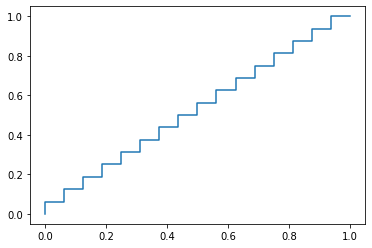

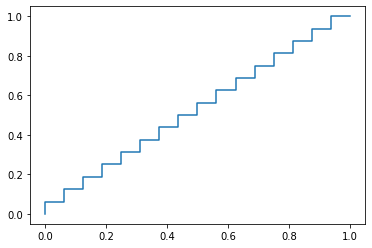

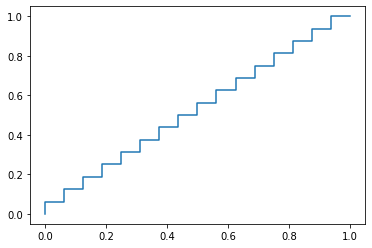

In [11]:
plot_division(Tau_non_f)
plot_division(Tau_non_g)
plot_division(Tau_non_h)

## Standard adaptive quadrature

The method is simple. In one iteration, the algorithm checks the difference between Simpson's rule for the whole subinterval $[u,v]$ and the sum of Simpson's rules for both halves. If the difference is within the specified tolerance, the algorithm finishes splitting.

In [12]:
def standard_adaptive_simpson_quadrature(f, a = 0.0, b = 1.0, epsilon = 0.000001, Time = time()):
    S1 = simpson_quadrature(f, a, b)
    S2 = simpson_quadrature(f, a, 0.5*(a+b)) + simpson_quadrature(f, 0.5*(a+b), b)
    if abs(S1 - S2) <= 15*epsilon:
        #Time = time() - Time
        #print(f'Time of execution: {str(Time)} seconds.')
        return S2
    return standard_adaptive_simpson_quadrature(f, a, 0.5*(a+b), 0.5*epsilon, Time) + standard_adaptive_simpson_quadrature(f, 0.5*(a+b), b, 0.5*epsilon, Time)

I will compute the values of the integrals with the target error less than that obtained in the non-adaptive integration.

In [13]:
S_std_f = standard_adaptive_simpson_quadrature(f, epsilon = 0.1)
S_std_g = standard_adaptive_simpson_quadrature(g, epsilon = 1.e-9)
S_std_h = standard_adaptive_simpson_quadrature(h, epsilon = 1.e-10)

print(f'S_std(f) = {S_std_f}')
print(f'S_std(g) = {S_std_g}')
print(f'S_std(h) = {S_std_h}')

S_std(f) = 0.3333333333333333
S_std(g) = 0.3011686785692952
S_std(h) = 1.9654538921749731


In [14]:
E_std_f = error_estimation(S_std_f, integral(int_f))
E_std_g = error_estimation(S_std_g, integral(int_g))
E_std_h = error_estimation(S_std_h, integral(int_h))

print(f'E_std(f) = {E_std_f}')
print(f'E_std(g) = {E_std_g}')
print(f'E_std(h) = {E_std_h}')

E_std(f) = 0.0
E_std(g) = -3.7046155032527395e-10
E_std(h) = 1.308220198836807e-11


The results have been improved. Of course, for function $f$, the result is accurate independently of the input error value. It remains to compare the number of attempts required to achieve it. It will look better, of course, with a smaller target error. After all, the performance is to be improved asymptotically. The following method works equivalently, but its purpose is to construct and list a split.

In [15]:
def standard_adaptive_simpson_quadrature_intervals(f, a = 0.0, b = 1.0, epsilon = 1.e-6):
    Stack1 = []
    Stack2 = []
    
    c = 0.5*(a+b)
    fl = f(a)
    fc = f(c)
    fr = f(b)
    S = Subinterval.simpson(a, b, fl, fc, fr)
    subinterval = Subinterval(left = a, right = b,
                      f_left = fl, f_center = fc, f_right = fr,
                      Simpson = S)
    
    Stack1.append(subinterval)
    
    while Stack1:
        subinterval = Stack1.pop()
        l = subinterval.left
        r = subinterval.right
        c = 0.5*(l+r)
        fl = subinterval.f_left
        fc = subinterval.f_center
        fr = subinterval.f_right
        cl = 0.5*(l+c)
        cr = 0.5*(c+r)
        fcl = f(cl)
        fcr = f(cr)
        
        Sleft = Subinterval.simpson(l, c, fl, fcl, fc)
        Sright = Subinterval.simpson(c, r, fc, fcr, fr)
        
        S1 = subinterval.Simpson
        S2 = Sleft + Sright
        
        subinterval1 = Subinterval(left = l, right = c,
                           f_left = fl, f_center = fcl, f_right = fc,
                           Simpson = Sleft)
        subinterval2 = Subinterval(left = c, right = r,
                           f_left = fc, f_center = fcr, f_right = fr,
                           Simpson = Sright)
        
        if abs(S1 - S2) <= 15.0*epsilon*(r - l)/(b - a):
            Stack2.append(subinterval1)
            Stack2.append(subinterval2)
        else:
            Stack1.append(subinterval1)
            Stack1.append(subinterval2)
    return Stack2

As seen below, the method (as opposed to the non-adaptive one) can end up with an uneven split. We see it in the case of the function $g$. For the function $f$, the algorithm stops at the first step - as expected.

n = 2


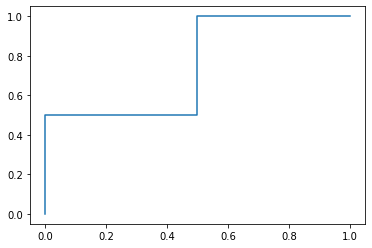

n = 50


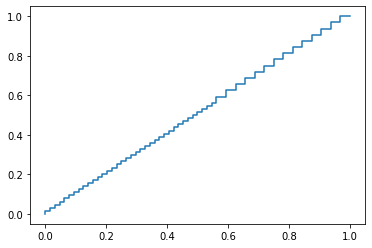

n = 64


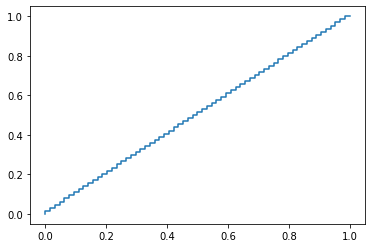

In [16]:
Tau_std_f = standard_adaptive_simpson_quadrature_intervals(f, epsilon = 0.1)
Tau_std_g = standard_adaptive_simpson_quadrature_intervals(g, epsilon = 1.e-9)
Tau_std_h = standard_adaptive_simpson_quadrature_intervals(h, epsilon = 1.e-10)

print(f'n = {len(Tau_std_f)}')
plot_division(Tau_std_f)
print(f'n = {len(Tau_std_g)}')
plot_division(Tau_std_g)
print(f'n = {len(Tau_std_h)}')
plot_division(Tau_std_h)

However, the standard method of adaptive integration has a disadvantage. The algorithm can stop prematurely with an incorrect result. An extreme example: integrating function $trap(x) = \Pi_{i=0}^4(x-i)^2$ na $[0,4]$. The integral of this function is obviously positive. In the first iteration, the algorithm stops, regardless of the input $\epsilon$ value, returning $0$.

In [17]:
def trap_constructor(x, n):
    if n <= -1:
        return 1.
    return (x-n)*(x-n)*trap_constructor(x, n-1)

trap = lambda x: trap_constructor(x, 4)
int_trap = lambda x: 192.*x**3 - 600.*x**4 + 836.*x**5 - (1990.*x**6)/3. + (2273.*x**7)/7. - 100.*x**8 + (170.*x**9)/9. - 2.*x**10 + x**11/11.

S_std_trap = standard_adaptive_simpson_quadrature(trap, a = 0., b = 4., epsilon = 1.e-10)
Int_trap = integral(int_trap, a = 0., b = 4.)
print(f'S_std(trap) = {S_std_trap}')
print(f'expected = {Int_trap}')

Tau_std_trap = standard_adaptive_simpson_quadrature_intervals(f, epsilon = 1.e-10)
print(f'n = {len(Tau_std_trap)}')

S_std(trap) = 0.0
expected = 14.776334776426665
n = 2


To eliminate the probability of such cases, the examined functions from class $C^{(4)}([a,b])$ should be limited to those that have a positive fourth derivative over the entire interval.

Of course, you can protect such cases by adding additional conditions to prevent the algorithm from terminating prematurely. I will solve it in the method below.

## Optimitized adaptation method

Now I will present an adaptive algorithm optimized for the number of calculations of the function value.

The first step of the algorithm is practically the standard algorithm presented above, but if the condition is not met, it is run with the same error on the input. Obviously, the resulting sum does not converge to the value of the integral. However, we get some division of $[a,b]$ into $m$ sub-intervals - and depending on $m$, we adjust the error in the second step.

In [18]:
def optimized_adaptive_simpson_quadrature(f, a = 0.0, b = 1.0, epsilon = 0.000001):
    Stack1 = []
    Stack2 = []
    
    c = 0.5*(a+b)
    fl = f(a)
    fc = f(c)
    fr = f(b)
    S = Subinterval.simpson(a, b, fl, fc, fr)
    subinterval = Subinterval(left = a, right = b,
                      f_left = fl, f_center = fc, f_right = fr,
                      Simpson = S)
    
    Stack1.append(subinterval)
    m = 0
    
    # get the subinterval from stack
    # if it satisfies the condition, delete
    # if not, add the halfs of the subinterval to the stack

    while Stack1:
        subinterval = Stack1.pop()
        l = subinterval.left
        r = subinterval.right
        c = 0.5*(l+r)
        fl = subinterval.f_left
        fc = subinterval.f_center
        fr = subinterval.f_right
        cl = 0.5*(l+c)
        cr = 0.5*(c+r)
        fcl = f(cl)
        fcr = f(cr)
        
        Sleft = Subinterval.simpson(l, c, fl, fcl, fc)
        Sright = Subinterval.simpson(c, r, fc, fcr, fr)
        
        S1 = subinterval.Simpson
        S2 = Sleft + Sright
        
        subinterval1 = Subinterval(left = l, right = c,
                           f_left = fl, f_center = fcl, f_right = fc,
                           Simpson = Sleft)
        subinterval2 = Subinterval(left = c, right = r,
                           f_left = fc, f_center = fcr, f_right = fr,
                           Simpson = Sright)
        
        if abs(S1 - S2) <= 15.0*epsilon:
            m += 1
            Stack2.append(subinterval1)
            Stack2.append(subinterval2)
        else:
            Stack1.append(subinterval1)
            Stack1.append(subinterval2)
           
    # adjust the error to optimal value B = 4^(5/4)
    epsilon1 = epsilon*(0.25*m)**(-1.25)
    result = 0.0
    
    while Stack2:
        subinterval = Stack2.pop()
        l = subinterval.left
        r = subinterval.right
        c = 0.5*(l+r)
        fl = subinterval.f_left
        fc = subinterval.f_center
        fr = subinterval.f_right
        cl = 0.5*(l+c)
        cr = 0.5*(c+r)
        fcl = f(cl)
        fcr = f(cr)
        
        Sleft = Subinterval.simpson(l, c, fl, fcl, fc)
        Sright = Subinterval.simpson(c, r, fc, fcr, fr)
        
        S1 = subinterval.Simpson
        S2 = Sleft + Sright
        
        if abs(S1 - S2) <= 15.0*epsilon1:
            result += S2
        else:
            subinterval1 = Subinterval(left = l, right = c,
                           f_left = fl, f_center = fcl, f_right = fc,
                           Simpson = Sleft)
            subinterval2 = Subinterval(left = c, right = r,
                           f_left = fc, f_center = fcr, f_right = fr,
                           Simpson = Sright)
            Stack2.append(subinterval1)
            Stack2.append(subinterval2)
            
    return result

In [19]:
S_opt_f = standard_adaptive_simpson_quadrature(f, epsilon = 1.e-10)
S_opt_g = standard_adaptive_simpson_quadrature(g, epsilon = 1.e-10)
S_opt_h = standard_adaptive_simpson_quadrature(h, epsilon = 1.e-10)

print(f'S_opt(f) = {S_opt_f}')
print(f'S_opt(g) = {S_opt_g}')
print(f'S_opt(h) = {S_opt_h}')

S_opt(f) = 0.3333333333333333
S_opt(g) = 0.30116867887632853
S_opt(h) = 1.9654538921749731


In [20]:
E_opt_f = error_estimation(S_opt_f, integral(int_f))
E_opt_g = error_estimation(S_opt_g, integral(int_g))
E_opt_h = error_estimation(S_opt_h, integral(int_h))

print(f'E_opt(f) = {E_opt_f}')
print(f'E_opt(g) = {E_opt_g}')
print(f'E_opt(h) = {E_opt_h}')

E_opt(f) = 0.0
E_opt(g) = -6.342820713101105e-11
E_opt(h) = 1.308220198836807e-11


As you can see, the algorithm computes the correct values. Let's see at what rate the given result was achieved.

In [21]:
def optimized_adaptive_simpson_quadrature_intervals(f, a = 0.0, b = 1.0, epsilon = 0.000001):
    Stack1 = []
    Stack2 = []
    Subintervals = []
    
    c = 0.5*(a+b)
    fl = f(a)
    fc = f(c)
    fr = f(b)
    S = Subinterval.simpson(a, b, fl, fc, fr)
    subinterval = Subinterval(left = a, right = b,
                      f_left = fl, f_center = fc, f_right = fr,
                      Simpson = S)
    
    Stack1.append(subinterval)
    m = 0
    
    while Stack1:
        subinterval = Stack1.pop()
        l = subinterval.left
        r = subinterval.right
        c = 0.5*(l+r)
        fl = subinterval.f_left
        fc = subinterval.f_center
        fr = subinterval.f_right
        cl = 0.5*(l+c)
        cr = 0.5*(c+r)
        fcl = f(cl)
        fcr = f(cr)
        
        Sleft = Subinterval.simpson(l, c, fl, fcl, fc)
        Sright = Subinterval.simpson(c, r, fc, fcr, fr)
        
        S1 = subinterval.Simpson
        S2 = Sleft + Sright
        
        subinterval1 = Subinterval(left = l, right = c,
                           f_left = fl, f_center = fcl, f_right = fc,
                           Simpson = Sleft)
        subinterval2 = Subinterval(left = c, right = r,
                           f_left = fc, f_center = fcr, f_right = fr,
                           Simpson = Sright)
        
        if abs(S1 - S2) <= 15.0*epsilon:
            m += 1
            Stack2.append(subinterval1)
            Stack2.append(subinterval2)
        else:
            Stack1.append(subinterval1)
            Stack1.append(subinterval2)
            
    epsilon1 = epsilon*(0.25*m)**(-1.25)
    result = 0.0
    
    while Stack2:
        subinterval = Stack2.pop()
        l = subinterval.left
        r = subinterval.right
        c = 0.5*(l+r)
        fl = subinterval.f_left
        fc = subinterval.f_center
        fr = subinterval.f_right
        cl = 0.5*(l+c)
        cr = 0.5*(c+r)
        fcl = f(cl)
        fcr = f(cr)
        
        Sleft = Subinterval.simpson(l, c, fl, fcl, fc)
        Sright = Subinterval.simpson(c, r, fc, fcr, fr)
        
        S1 = subinterval.Simpson
        S2 = Sleft + Sright
        
        subinterval1 = Subinterval(left = l, right = c,
                           f_left = fl, f_center = fcl, f_right = fc,
                           Simpson = Sleft)
        subinterval2 = Subinterval(left = c, right = r,
                           f_left = fc, f_center = fcr, f_right = fr,
                           Simpson = Sright)
        
        if abs(S1 - S2) <= 15.0*epsilon1:
            Subintervals.append(subinterval1)
            Subintervals.append(subinterval2)
        else:
            
            Stack2.append(subinterval1)
            Stack2.append(subinterval2)
            
    return Subintervals

n = 4


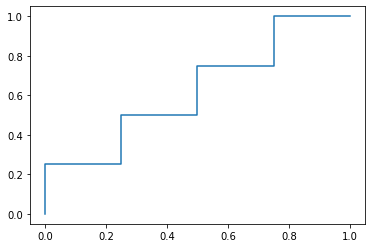

n = 64


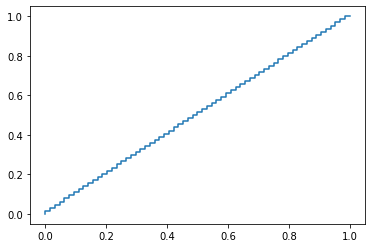

n = 64


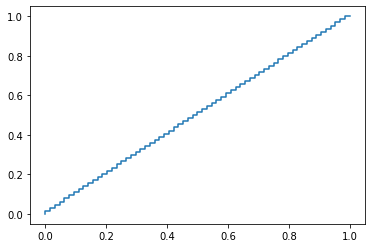

In [22]:
Tau_opt_f = optimized_adaptive_simpson_quadrature_intervals(f, epsilon = 0.1)
Tau_opt_g = optimized_adaptive_simpson_quadrature_intervals(g, epsilon = 1.e-9)
Tau_opt_h = optimized_adaptive_simpson_quadrature_intervals(h, epsilon = 1.e-10)

print(f'n = {len(Tau_opt_f)}')
plot_division(Tau_opt_f)
print(f'n = {len(Tau_opt_g)}')
plot_division(Tau_opt_g)
print(f'n = {len(Tau_opt_h)}')
plot_division(Tau_opt_h)

For a smaller number of iterations, the algorithm is comparable to the standard adaptive method.

Let's see if the algorithm coped with the previously wrongly approximated function $trap$.

In [23]:
S_opt_trap = optimized_adaptive_simpson_quadrature(trap, a = 0., b = 4., epsilon = 1.e-10)
print(f'S_opt(trap) = {S_opt_trap}')
print(f'expected = {Int_trap}')

E_opt_trap = error_estimation(S_opt_trap, Int_trap)
print(f'E_opt(trap) = {E_opt_trap}')

Tau_opt_trap = optimized_adaptive_simpson_quadrature_intervals(f, epsilon = 1.e-10)
print(f'n = {len(Tau_opt_trap)}')

S_opt(trap) = 14.776334781699525
expected = 14.776334776426665
E_opt(trap) = 5.27285948237477e-09
n = 4


This time the algorithm worked fine and stopped fairly quickly for an error of $10^{-10}$.

### Performance for test functions with less expected error

I will now test the operation of the three algorithms for the smaller expected error for the test functions $g$ and $h$. First, I will calculate the error for the non-adaptive algorithm with a large $n$, say $n = 1048576 = 2^{20}$.

In [24]:
Time_non_g2 = time()
S_non_g2 = simpson_quadrature(g, n = 2**20)
Time_non_g2 = time() - Time_non_g2
print(f'S_non2(g) = {S_non_g2}')
print(f'Time_non2(g) = {Time_non_g2}s')
E_non_g2 = error_estimation(S_non_g2, expected = integral(int_g))
print(f'E_non2(g) = {E_non_g2}')

print()

Time_non_h2 = time()
S_non_h2 = simpson_quadrature(h, n = 2**20)
Time_non_h2 = time() - Time_non_h2
print(f'S_non2(h) = {S_non_h2}')
print(f'Time_non2(h) = {Time_non_h2}s')
E_non_h2 = error_estimation(S_non_h2, expected = integral(int_h))
print(f'E_non2(h) = {E_non_h2}')

S_non2(g) = 0.30116867893976007
Time_non2(g) = 0.7541799545288086s
E_non2(g) = 3.3306690738754696e-15

S_non2(h) = 1.9654538921619
Time_non2(h) = 0.855196475982666s
E_non2(h) = 9.103828801926284e-15


I will try to achieve the error as above for the adaptive algorithms.

In [25]:
Time_std_g2 = time()
S_std_g2 = standard_adaptive_simpson_quadrature(g, epsilon = E_non_g2)
Time_std_g2 = time() - Time_std_g2
print(f'S_std2(g) = {S_std_g2}')
print(f'Time_std2(g) = {Time_std_g2}s')
E_std_g2 = error_estimation(S_std_g2, expected = integral(int_g))
print(f'E_std2(g) = {E_std_g2}')

print()

Time_opt_g2 = time()
S_opt_g2 = optimized_adaptive_simpson_quadrature(g, epsilon = E_non_g2)
Time_opt_g2 = time() - Time_opt_g2
print(f'S_opt2(g) = {S_opt_g2}')
print(f'Time_opt2(g) = {Time_opt_g2}s')
E_opt_g2 = error_estimation(S_opt_g2, expected = integral(int_g))
print(f'E_opt2(g) = {E_opt_g2}')

S_std2(g) = 0.3011686789397558
Time_std2(g) = 0.008173704147338867s
E_std2(g) = -9.43689570931383e-16

S_opt2(g) = 0.30116867893975413
Time_opt2(g) = 0.0016171932220458984s
E_opt2(g) = -2.609024107869118e-15


In [26]:
Time_std_h2 = time()
S_std_h2 = standard_adaptive_simpson_quadrature(h, epsilon = E_non_h2)
Time_std_h2 = time() - Time_std_h2
print(f'S_std2(h) = {S_std_h2}')
print(f'Time_std2(h) = {Time_std_h2}s')
E_std_h2 = error_estimation(S_std_h2, expected = integral(int_h))
print(f'E_std2(h) = {E_std_h2}')

print()

Time_opt_h2 = time()
S_opt_h2 = optimized_adaptive_simpson_quadrature(h, epsilon = E_non_h2)
Time_opt_h2 = time() - Time_opt_h2
print(f'S_opt2(h) = {S_opt_h2}')
print(f'Time_opt2(h) = {Time_opt_h2}s')
E_opt_h2 = error_estimation(S_opt_h2, expected = integral(int_h))
print(f'E_opt2(h) = {E_opt_h2}')

S_std2(h) = 1.965453892161894
Time_std2(h) = 0.004338741302490234s
E_std2(h) = 3.1086244689504383e-15

S_opt2(h) = 1.9654538921618947
Time_opt2(h) = 0.0009777545928955078s
E_opt2(h) = 3.774758283725532e-15


Let's see what the subdivision looks like for the above results:

n = 1024


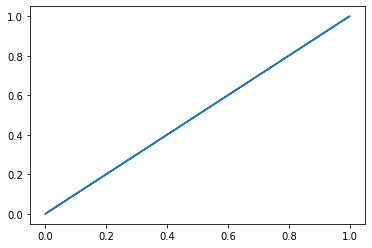

n = 922


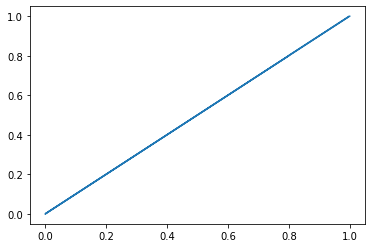

In [27]:
Tau_std_g2 = standard_adaptive_simpson_quadrature_intervals(g, epsilon = E_non_g2)
Tau_opt_g2 = optimized_adaptive_simpson_quadrature_intervals(g, epsilon = E_non_g2)

print(f'n = {len(Tau_std_g2)}')
plot_division(Tau_std_g2)
print(f'n = {len(Tau_opt_g2)}')
plot_division(Tau_opt_g2)

n = 512


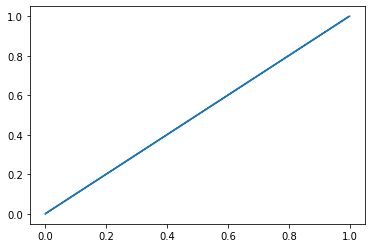

n = 512


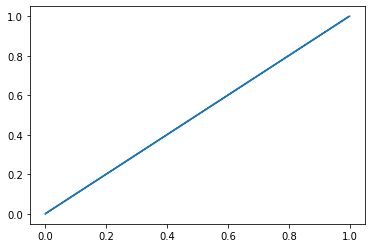

In [28]:
Tau_std_h2 = standard_adaptive_simpson_quadrature_intervals(h, epsilon = E_non_h2)
Tau_opt_h2 = optimized_adaptive_simpson_quadrature_intervals(h, epsilon = E_non_h2)

print(f'n = {len(Tau_std_h2)}')
plot_division(Tau_std_h2)
print(f'n = {len(Tau_opt_h2)}')
plot_division(Tau_opt_h2)

As you can see, the number of divisions is comparable.

### Comparing algorithms for functions with the singular point at the end of the interval.

The real advantage of an optimized algorithm can only be achieved with functions that have a large limitation of the fourth derivative on the input interval. For example - let's take a function $k(x) = \frac{1}{2\sqrt{x}}$ on the interval $[\delta,1]$, where $\delta = 10^{-8}$, which guarantees quite large $f^{(4)}$ values close to the left end of the interval.

In [29]:
k = lambda x: 0.5/sqrt(x)
int_k = lambda x: sqrt(x)
delta = 1.e-8

As before - in the first step, I will use the non-adaptive method for big $n$ and run the adaptive algorithms with the error received.

In [30]:
S_non_k = simpson_quadrature(k, a = delta, b = 1., n = 2**20)
print(f'S_non(k) = {S_non_k}')

E_non_k = error_estimation(S_non_k, expected = integral(int_k, a = delta, b = 1.))
print(f'E_non(k) = {E_non_k}')

S_non(k) = 1.0003498438327807
E_non(k) = 0.00044984383278068307


The received error is too big to be accepted for such a dense grid.

In [31]:
S_std_k = standard_adaptive_simpson_quadrature(k, a = delta, b = 1., epsilon = E_non_k)
print(f'S_std(k) = {S_std_k}')
E_std_k = error_estimation(S_std_k, expected = integral(int_k, a = delta, b = 1.))
print(f'E_std(k) = {E_std_k}')

S_opt_k = optimized_adaptive_simpson_quadrature(k, a = delta, b = 1., epsilon = E_non_k)
print(f'S_opt(k) = {S_opt_k}')
E_opt_k = error_estimation(S_opt_k, expected = integral(int_k, a = delta, b = 1.))
print(f'E_opt(k) = {E_opt_k}')

S_std(k) = 0.9999389575015398
E_std(k) = 3.895750153981581e-05
S_opt(k) = 1.000352624007697
E_opt(k) = 0.00045262400769696676


n = 132


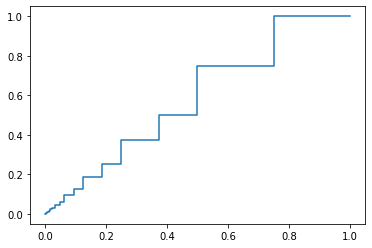

n = 72


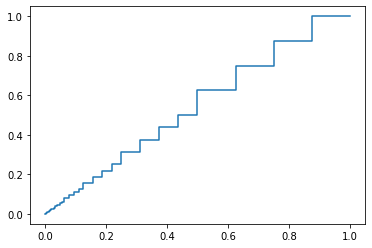

In [32]:
Tau_std_k = standard_adaptive_simpson_quadrature_intervals(k, a = delta, b = 1., epsilon = E_non_k)
Tau_opt_k = optimized_adaptive_simpson_quadrature_intervals(k, a = delta, b = 1., epsilon = E_non_k)

print(f'n = {len(Tau_std_k)}')
plot_division(Tau_std_k)
print(f'n = {len(Tau_opt_k)}')
plot_division(Tau_opt_k)

For the adaptive algorithms, there is a noticeable approximation improvement with a significantly smaller partition number. The structure of the partition is as expected - the closer to the left edge, the denser the grid. Let's see how the adaptive algorithms behave for a smaller input error.

In [33]:
epsilon_k = 1.e-11

S_std_k2 = standard_adaptive_simpson_quadrature(k, a = delta, b = 1., epsilon = epsilon_k)
print(f'S_std2(k) = {S_std_k2}')
E_std_k2 = error_estimation(S_std_k, expected = integral(int_k, a = delta, b = 1.))
print(f'E_std2(k) = {E_std_k2}')

print()

S_opt_k2 = optimized_adaptive_simpson_quadrature(k, a = delta, b = 1., epsilon = epsilon_k)
print(f'S_opt2(k) = {S_opt_k2}')
E_opt_k2 = error_estimation(S_opt_k, expected = integral(int_k, a = delta, b = 1.))
print(f'E_opt2(k) = {E_opt_k2}')

S_std2(k) = 0.9999000000035783
E_std2(k) = 3.895750153981581e-05

S_opt2(k) = 0.9999000000093438
E_opt2(k) = 0.00045262400769696676


n = 110


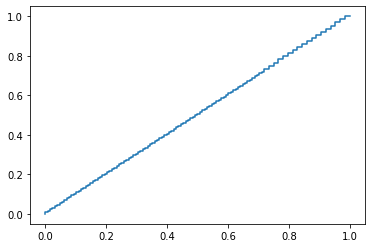

n = 112


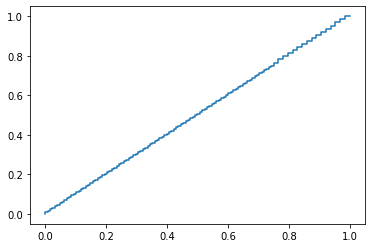

In [34]:
Tau_std_k2 = standard_adaptive_simpson_quadrature_intervals(h, a = delta, b = 1., epsilon = epsilon_k)
Tau_opt_k2 = optimized_adaptive_simpson_quadrature_intervals(h, a = delta, b = 1., epsilon = epsilon_k)

print(f'n = {len(Tau_std_k2)}')
plot_division(Tau_std_k2)
print(f'n = {len(Tau_opt_k2)}')
plot_division(Tau_opt_k2)

Finally, I will compare the number of sub-intervals on the output generated by the standard algorithm and the one optimized for the function $k$ for different input errors, starting with $10^{-1}$.

In [35]:
def adaptive_integrals_comparison(f, int_f, a: float = 0., b: float = 1., log_eps1: int = 5, log_eps2: int = 12):
    eps_list = [.1**i for i in range(log_eps1,log_eps2+1)]

    Tau_std_list = []
    Tau_opt_list = []

    E_std_list = []
    E_opt_list = []
    
    for eps in eps_list:
        S_std = standard_adaptive_simpson_quadrature(f, a, b, epsilon = eps)
        S_opt = optimized_adaptive_simpson_quadrature(f, a, b, epsilon = eps)

        E_std = error_estimation(S_std, integral(int_f, a, b))
        E_opt = error_estimation(S_opt, integral(int_f, a, b))

        E_std_list.append(E_std)
        E_opt_list.append(E_opt)

        Tau_std = standard_adaptive_simpson_quadrature_intervals(f, a, b, epsilon = eps)
        Tau_opt = optimized_adaptive_simpson_quadrature_intervals(f, a, b, epsilon = eps)

        Tau_std_list.append(len(Tau_std))
        Tau_opt_list.append(len(Tau_opt))

    plt.plot(E_std_list, Tau_std_list, color = 'r')
    plt.plot(E_opt_list, Tau_opt_list, color = 'g')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.gca().invert_xaxis()
    plt.show()

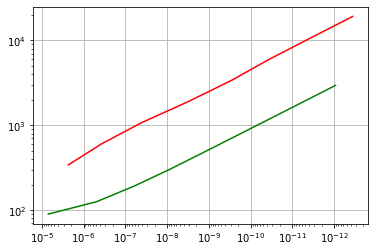

In [36]:
adaptive_integrals_comparison(k, int_k, a = delta, b = 1.)

The chart above shows the trend of both algorithms - for a sufficiently large number of divisions, the optimized algorithm will be better than the standard one.

### Summary

Adaptive methods work great for functions with a high fourth derivative bound, especially those that have a singular point at the end of the interval. The standard adaptive algorithm has a vulnerability that allows premature termination, but such cases can be eliminated by optimizing the algorithm. The non-adaptive quadrature division grid is uniform, while for adaptive quadratures (with n sufficiently large) the node density increases with the limitation of the fourth derivative on the sub-interval, which is also particularly visible for the function with the singular point at the end of the interval.